# **Milestone**-1

## Imports

In [1]:
import os
import shutil
import random
import zipfile
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, array_to_img
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_recall_fscore_support

# Google Colab Specific
from google.colab import files

import wandb
from wandb.integration.keras import WandbCallback

print("All libraries imported successfully!")

All libraries imported successfully!


In [2]:
!pip install wandb
wandb.login()

/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)
wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visualize my results
wandb: Enter your choice:

 2


wandb: You chose 'Use an existing W&B account'
wandb: Logging into https://api.wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: Find your API key here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: mdfirozwadud (BME_DeepLearning) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

### **Download Dataset**
We are using the Dataset from the kaggle.
Here is the link: https://www.kaggle.com/datasets/marcopinamonti/alzheimer-mri-4-classes-dataset


In [3]:
!pip install kaggle

from google.colab import files
files.upload()

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [4]:
!kaggle datasets download -d marcopinamonti/alzheimer-mri-4-classes-dataset

!unzip alzheimer-mri-4-classes-dataset.zip -d /content/dataset

Streaming output truncated to the last 5000 lines.
  inflating: /content/dataset/Alzheimer_MRI_4_classes_dataset/NonDemented/13 (46).jpg  
  inflating: /content/dataset/Alzheimer_MRI_4_classes_dataset/NonDemented/13 (47).jpg  
  inflating: /content/dataset/Alzheimer_MRI_4_classes_dataset/NonDemented/13 (48).jpg  
  inflating: /content/dataset/Alzheimer_MRI_4_classes_dataset/NonDemented/13 (49).jpg  
  inflating: /content/dataset/Alzheimer_MRI_4_classes_dataset/NonDemented/13 (5).jpg  
  inflating: /content/dataset/Alzheimer_MRI_4_classes_dataset/NonDemented/13 (50).jpg  
  inflating: /content/dataset/Alzheimer_MRI_4_classes_dataset/NonDemented/13 (51).jpg  
  inflating: /content/dataset/Alzheimer_MRI_4_classes_dataset/NonDemented/13 (52).jpg  
  inflating: /content/dataset/Alzheimer_MRI_4_classes_dataset/NonDemented/13 (53).jpg  
  inflating: /content/dataset/Alzheimer_MRI_4_classes_dataset/NonDemented/13 (54).jpg  
  inflating: /content/dataset/Alzheimer_MRI_4_classes_dataset/NonDemen

In [5]:
source_dir = '/content/dataset/Alzheimer_MRI_4_classes_dataset'
output_dir = '/content/split_dataset'

for cls in os.listdir(source_dir):
    cls_path = os.path.join(source_dir, cls)
    if not os.path.isdir(cls_path):
        continue

    images = os.listdir(cls_path)
    train, temp = train_test_split(images, test_size=0.3, random_state=42)
    val, test = train_test_split(temp, test_size=0.33, random_state=42)

    for split, imgs in [('train', train), ('val', val), ('test', test)]:
        dest = os.path.join(output_dir, split, cls)
        os.makedirs(dest, exist_ok=True)
        for img in imgs:
            shutil.copy(os.path.join(cls_path, img), os.path.join(dest, img))

print("Dataset split complete (70% train, 20% val, 10% test)")

Dataset split complete (70% train, 20% val, 10% test)


## **Data Visualization Before Preprocessing**

In [6]:
train_dir = f'{output_dir}/train'
classes = sorted(os.listdir(train_dir))
counts = {s: {c: len(os.listdir(f'{output_dir}/{s}/{c}')) for c in classes}
          for s in ['train', 'val', 'test']}

### **Original Dataset: Image Distribution Across Train/Val/Test Splits**

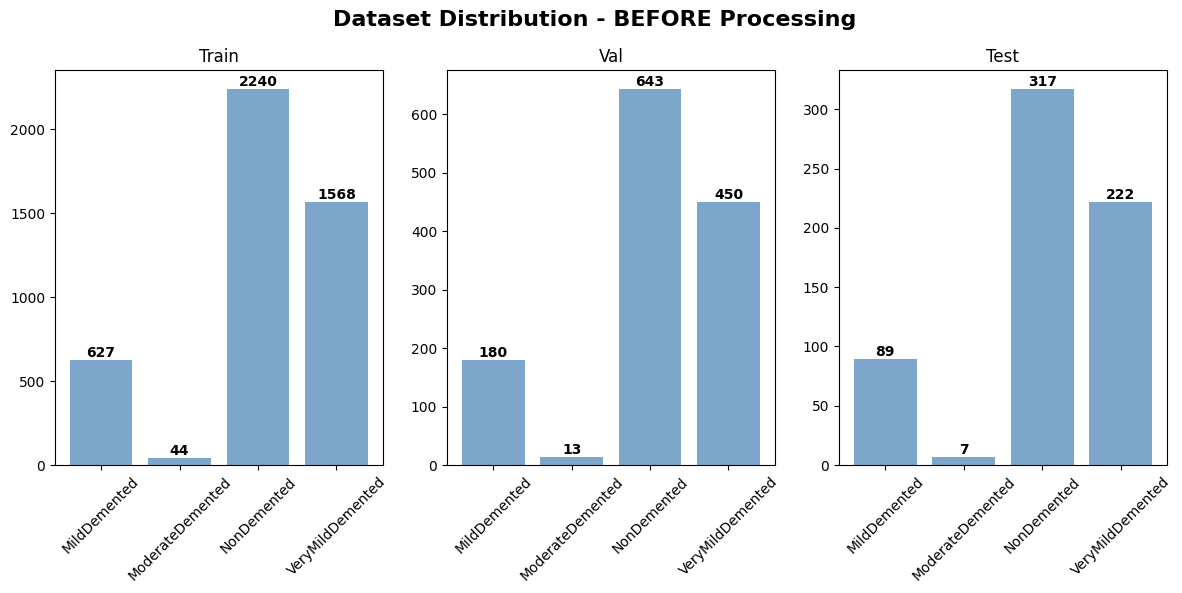

In [7]:
fig, axes = plt.subplots(1, 3, figsize=(12, 6))
fig.suptitle('Dataset Distribution - BEFORE Processing', fontsize=16, fontweight='bold')
for ax, (split, data) in zip(axes, counts.items()):
    bars = ax.bar(data.keys(), data.values(), color='steelblue', alpha=0.7)
    ax.set_title(split.capitalize(), fontsize=12)
    ax.tick_params(axis='x', rotation=45)
    for bar in bars:
        h = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, h, int(h), ha='center', va='bottom', fontweight='bold')
plt.tight_layout()
plt.show()

### **Visual Inspection: Random Samples from Each Class (Original Images)**

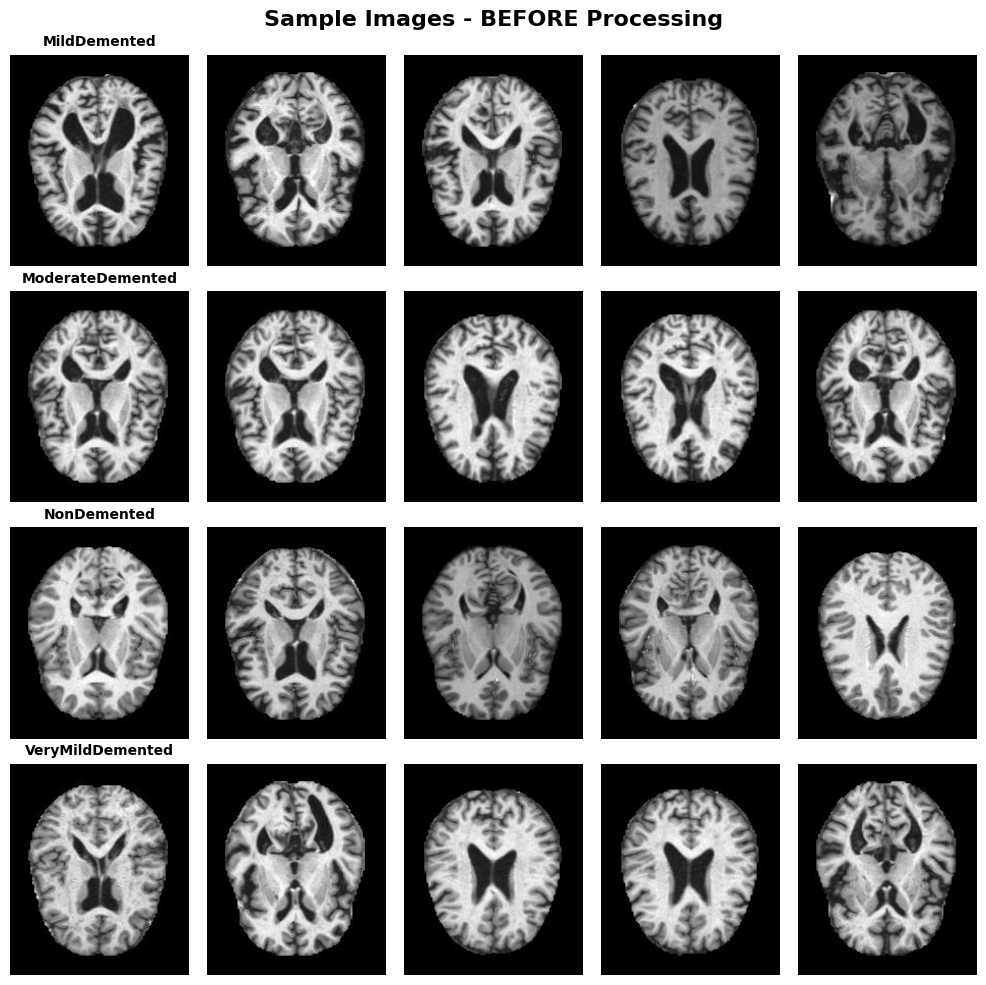

In [8]:
fig, axes = plt.subplots(len(classes), 5, figsize=(10, 10))
fig.suptitle('Sample Images - BEFORE Processing', fontsize=16, fontweight='bold')
for i, cls in enumerate(classes):
    imgs = random.sample(os.listdir(f'{train_dir}/{cls}'), min(5, len(os.listdir(f'{train_dir}/{cls}'))))
    for j, img in enumerate(imgs):
        axes[i, j].imshow(Image.open(f'{train_dir}/{cls}/{img}'), cmap='gray')
        axes[i, j].axis('off')
        if j == 0:
            axes[i, j].set_title(cls, fontweight='bold', fontsize=10)
plt.tight_layout()
plt.show()

### **Class Balance Analysis: Distribution Across Splits (Before Processing)**

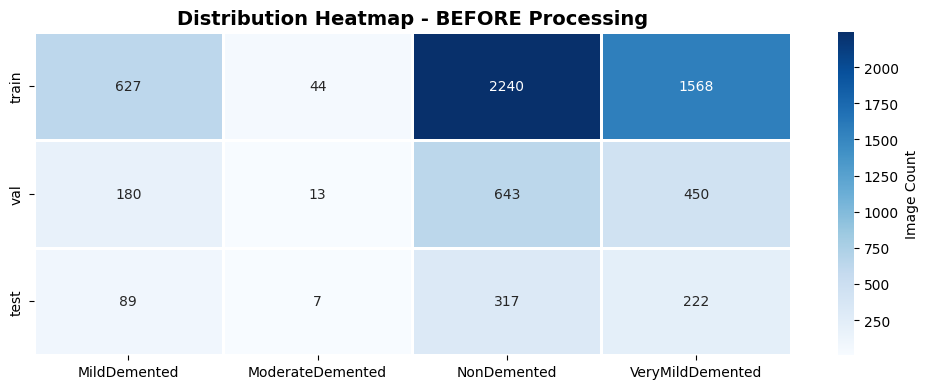

In [9]:
df = pd.DataFrame(counts).T
plt.figure(figsize=(10, 4))
sns.heatmap(df, annot=True, fmt='d', cmap='Blues', linewidths=1, cbar_kws={'label': 'Image Count'})
plt.title('Distribution Heatmap - BEFORE Processing', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

### **Dataset Summary Statistics**

In [10]:
print(f"Summary:")
print(f"Total: {df.sum().sum()} images")
print(f"Train: {df.loc['train'].sum()} | Val: {df.loc['val'].sum()} | Test: {df.loc['test'].sum()}")
print(f"Classes: {', '.join(classes)}")

Summary:
Total: 6400 images
Train: 4479 | Val: 1286 | Test: 635
Classes: MildDemented, ModerateDemented, NonDemented, VeryMildDemented


# **Milestone-2**

## **Deep Learning Model**

### **Preparing For Training**

In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1./255,
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    '/content/split_dataset/train',
    target_size=(208, 176),
    batch_size=32,
    class_mode='categorical',
    shuffle=True
)

val_generator = val_datagen.flow_from_directory(
    '/content/split_dataset/val',
    target_size=(208, 176),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 4479 images belonging to 4 classes.
Found 1286 images belonging to 4 classes.


In [12]:
# ==========================================
# DELETE OLD MODEL
# ==========================================
import tensorflow as tf
from tensorflow.keras import backend as K

K.clear_session()
del model

print("Old model cleared!")

NameError: name 'model' is not defined

## **Build Model And Train**

In [13]:
# Build Model
def conv_block(filters):
    return tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='elu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='elu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])

def dense_block(units, dropout_rate):
    return tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='elu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])

model = tf.keras.Sequential([
    tf.keras.Input(shape=(208, 176, 3)),

    tf.keras.layers.Conv2D(16, 3, activation='elu', padding='same'),
    tf.keras.layers.Conv2D(16, 3, activation='elu', padding='same'),
    tf.keras.layers.MaxPool2D(),

    conv_block(32),
    conv_block(64),
    conv_block(128),
    tf.keras.layers.Dropout(0.2),
    conv_block(256),
    tf.keras.layers.Dropout(0.2),

    tf.keras.layers.Flatten(),
    dense_block(512, 0.7),
    dense_block(128, 0.5),
    dense_block(64, 0.3),

    tf.keras.layers.Dense(4, activation='softmax')
])

In [14]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(
        learning_rate=0.0003,
        clipnorm=0.5
    ),
    loss=tf.keras.losses.CategoricalCrossentropy(
        label_smoothing=0.15
    ),
    metrics=[tf.keras.metrics.AUC(name='auc')]
)

print("Model compiled!")

Model compiled!


In [15]:
class_weights = {
    0: 2,      # MildDemented
    1: 5,      # ModerateDemented
    2: 1,      # NonDemented
    3: 1.3     # VeryMildDemented
}

print("Class weights:", class_weights)

Class weights: {0: 2, 1: 5, 2: 1, 3: 1.3}


In [16]:
wandb.init(
    project="alzheimer-mri-classification",
    name="NeuroVision_V1",
)

print("wandb initialized!")

wandb initialized!


In [17]:
callbacks = [
    # wandb tracking
    WandbCallback(
        monitor='val_auc',
        mode='max',
        save_model=False,
        save_graph=False
    ),

    # Stop ONLY if no improvement for 20 epochs
    tf.keras.callbacks.EarlyStopping(
        monitor='val_auc',
        patience=20,
        restore_best_weights=True,
        mode='max',
        verbose=1
    ),

    # Reduce LR very gradually
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_auc',
        factor=0.8,
        patience=10,
        min_lr=1e-7,
        mode='max',
        verbose=1
    ),

    # Save best model
    tf.keras.callbacks.ModelCheckpoint(
        'best_alzheimer_model.keras',
        monitor='val_auc',
        save_best_only=True,
        mode='max',
        verbose=0
    )
]

print("Callbacks configured")

wandb: WARNING WandbCallback is deprecated and will be removed in a future release. Please use the WandbMetricsLogger, WandbModelCheckpoint, and WandbEvalCallback callbacks instead. See https://docs.wandb.ai/guides/integrations/keras for more information.


Callbacks configured


In [18]:
history = model.fit(
    train_generator,
    epochs=50,
    validation_data=val_generator,
    class_weight=class_weights,
    callbacks=callbacks,
    verbose=1
)

print("\n Training completed!")


Epoch 1/50


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


140/140 ━━━━━━━━━━━━━━━━━━━━ 81s 332ms/step - auc: 0.5762 - loss: 2.4841 - val_auc: 0.5399 - val_loss: 1.2830 - learning_rate: 3.0000e-04
Epoch 2/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 9s 66ms/step - auc: 0.6729 - loss: 1.9661 - val_auc: 0.7956 - val_loss: 1.2162 - learning_rate: 3.0000e-04
Epoch 3/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 9s 64ms/step - auc: 0.7003 - loss: 1.8662 - val_auc: 0.6264 - val_loss: 1.3204 - learning_rate: 3.0000e-04
Epoch 4/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 10s 69ms/step - auc: 0.7565 - loss: 1.6797 - val_auc: 0.8269 - val_loss: 1.1574 - learning_rate: 3.0000e-04
Epoch 5/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 9s 64ms/step - auc: 0.7837 - loss: 1.6112 - val_auc: 0.7803 - val_loss: 1.8619 - learning_rate: 3.0000e-04
Epoch 6/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 9s 65ms/step - auc: 0.8092 - loss: 1.5526 - val_auc: 0.7464 - val_loss: 2.4010 - learning_rate: 3.0000e-04
Epoch 7/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 9s 66ms/step - auc: 0.8335 - loss: 1.4846 - val_auc: 0.5671 - val_loss: 2.0305 - learn

### Training and Validation Loss and Accuracy

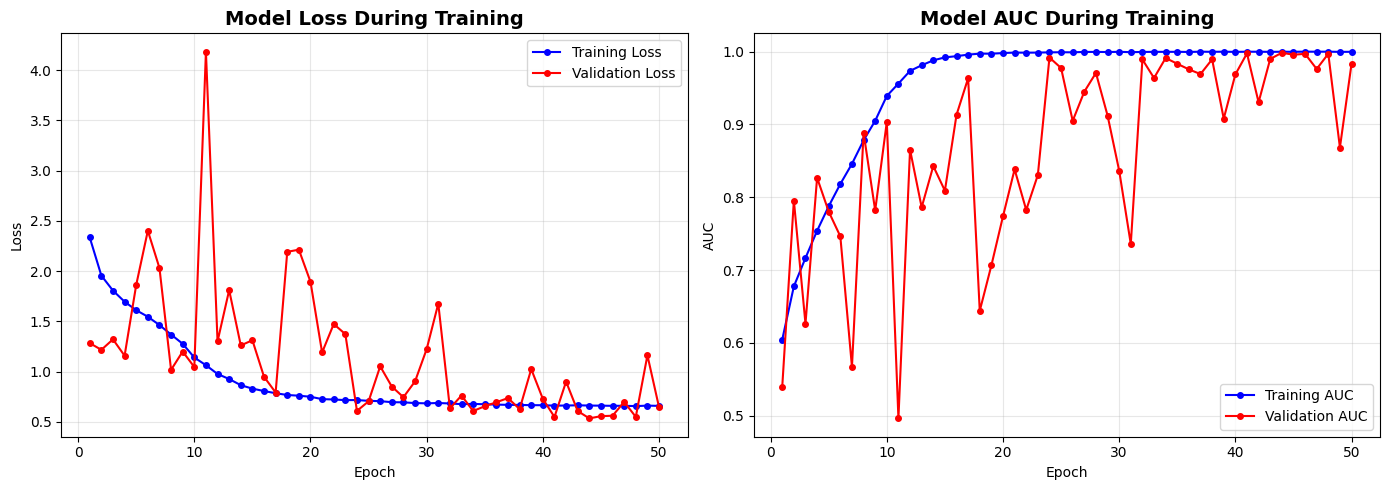


Model trained for 50 epochs
Best validation AUC: 0.9984 at epoch 44
Best validation loss: 0.5339 at epoch 44
Final training AUC: 0.9998
Final validation AUC: 0.9832


In [19]:
# Plot training history
import matplotlib.pyplot as plt

# Get the number of epochs the model actually trained
num_epochs = len(history.history['loss'])
epochs = list(range(1, num_epochs + 1))

# Extract metrics (note: using 'auc' not 'accuracy')
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_auc = history.history['auc']
val_auc = history.history['val_auc']

# Plot
plt.figure(figsize=(14, 5))

# First plot: Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'b-o', label='Training Loss', markersize=4)
plt.plot(epochs, val_loss, 'r-o', label='Validation Loss', markersize=4)
plt.title('Model Loss During Training', fontsize=14, fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

# Second plot: AUC (not accuracy)
plt.subplot(1, 2, 2)
plt.plot(epochs, train_auc, 'b-o', label='Training AUC', markersize=4)
plt.plot(epochs, val_auc, 'r-o', label='Validation AUC', markersize=4)
plt.title('Model AUC During Training', fontsize=14, fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print summary
print(f"\nModel trained for {num_epochs} epochs")
print(f"Best validation AUC: {max(val_auc):.4f} at epoch {val_auc.index(max(val_auc)) + 1}")
print(f"Best validation loss: {min(val_loss):.4f} at epoch {val_loss.index(min(val_loss)) + 1}")
print(f"Final training AUC: {train_auc[-1]:.4f}")
print(f"Final validation AUC: {val_auc[-1]:.4f}")

In [20]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create test generator
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    '/content/split_dataset/test',
    target_size=(208, 176),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

print(f"Found {test_generator.samples} test images")
print(f"Classes: {test_generator.class_indices}")

Found 635 images belonging to 4 classes.
Found 635 test images
Classes: {'MildDemented': 0, 'ModerateDemented': 1, 'NonDemented': 2, 'VeryMildDemented': 3}


In [21]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

print("Starting evaluation...")

# Reset generator to start from beginning
test_generator.reset()

# Get predictions
print("Generating predictions...")
predictions_proba = model.predict(test_generator, verbose=1)
predictions = np.argmax(predictions_proba, axis=1)

# Get true labels
true_labels = test_generator.classes

# Get class names
class_names = list(test_generator.class_indices.keys())

print(f"\nTotal test samples: {len(true_labels)}")
print(f"Predictions shape: {predictions_proba.shape}")
print(f"Classes: {class_names}")

Starting evaluation...
Generating predictions...
20/20 ━━━━━━━━━━━━━━━━━━━━ 11s 444ms/step

Total test samples: 635
Predictions shape: (635, 4)
Classes: ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']


### Confusion Matrix

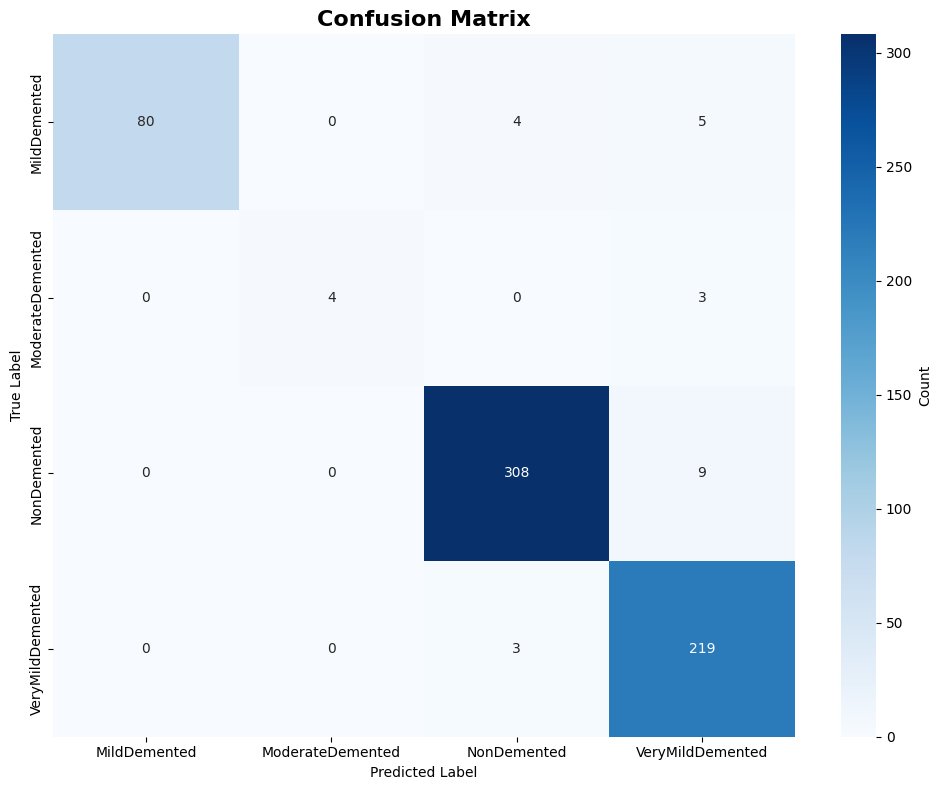


Per-class breakdown:
MildDemented        :  80/ 89 = 89.89%
ModerateDemented    :   4/  7 = 57.14%
NonDemented         : 308/317 = 97.16%
VeryMildDemented    : 219/222 = 98.65%


In [22]:
import seaborn as sns

# Calculate confusion matrix
cm = confusion_matrix(true_labels, predictions)

# Plot
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names,
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix', fontsize=16, fontweight='bold')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

# Print per-class accuracy
print("\nPer-class breakdown:")
for i, class_name in enumerate(class_names):
    correct = cm[i, i]
    total = cm[i, :].sum()
    accuracy = correct / total if total > 0 else 0
    print(f"{class_name:20s}: {correct:3d}/{total:3d} = {accuracy:.2%}")

### Classification Report

In [23]:
print("\n" + "="*70)
print("CLASSIFICATION REPORT")
print("="*70)
print(classification_report(true_labels, predictions,
                          target_names=class_names,
                          digits=4))


CLASSIFICATION REPORT
                  precision    recall  f1-score   support

    MildDemented     1.0000    0.8989    0.9467        89
ModerateDemented     1.0000    0.5714    0.7273         7
     NonDemented     0.9778    0.9716    0.9747       317
VeryMildDemented     0.9280    0.9865    0.9563       222

        accuracy                         0.9622       635
       macro avg     0.9764    0.8571    0.9013       635
    weighted avg     0.9637    0.9622    0.9616       635



### ROC Curve

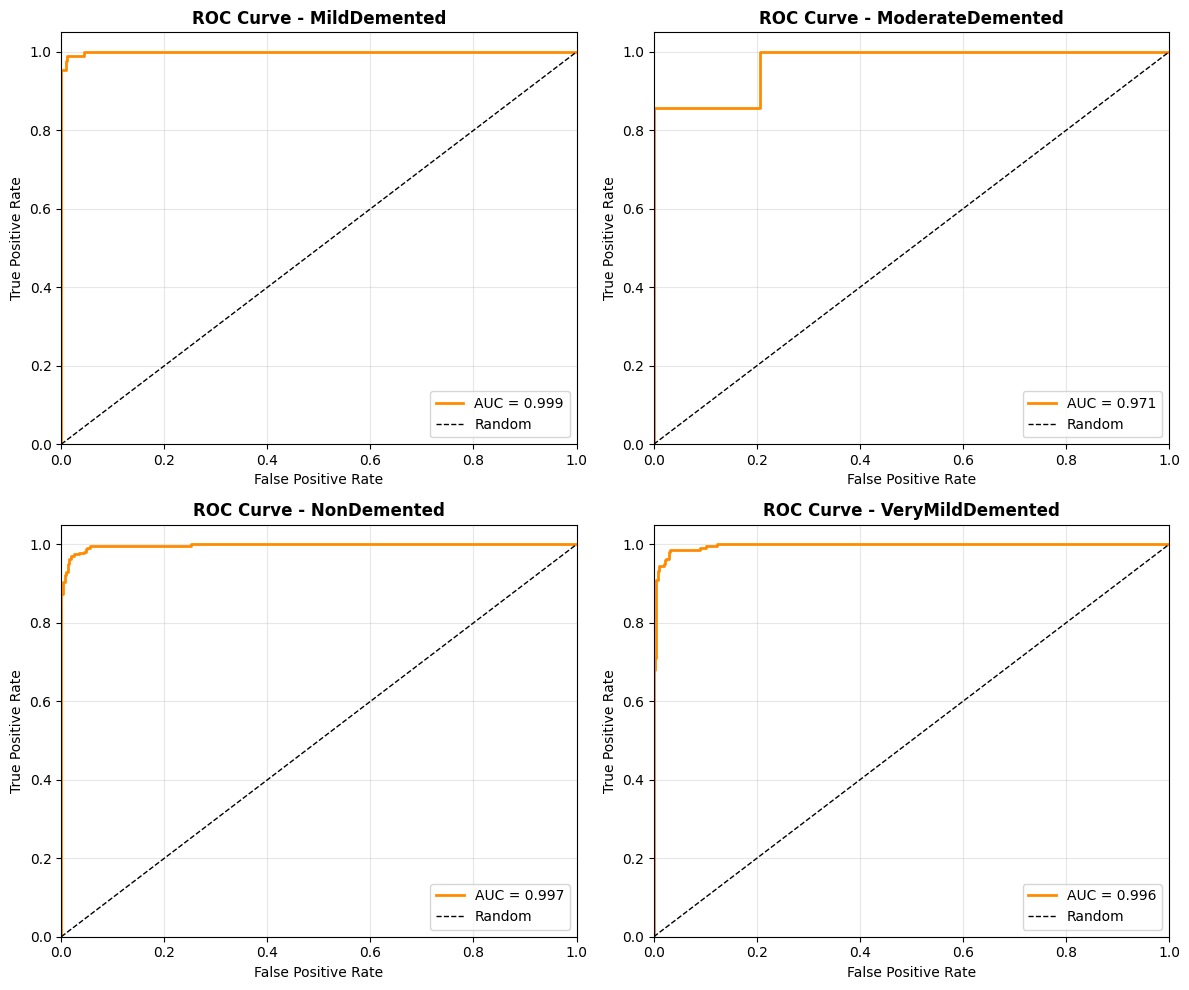


Per-class AUC:
MildDemented        : 0.9992
ModerateDemented    : 0.9707
NonDemented         : 0.9972
VeryMildDemented    : 0.9962


In [24]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

# Binarize labels for multi-class ROC
y_test_bin = label_binarize(true_labels, classes=range(len(class_names)))

plt.figure(figsize=(12, 10))

# Calculate and plot ROC for each class
for i, class_name in enumerate(class_names):
    # Calculate ROC curve
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], predictions_proba[:, i])
    roc_auc = auc(fpr, tpr)

    # Plot
    plt.subplot(2, 2, i+1)
    plt.plot(fpr, tpr, linewidth=2, label=f'AUC = {roc_auc:.3f}', color='darkorange')
    plt.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=10)
    plt.ylabel('True Positive Rate', fontsize=10)
    plt.title(f'ROC Curve - {class_name}', fontweight='bold', fontsize=12)
    plt.legend(loc='lower right')
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print overall AUC
print("\nPer-class AUC:")
for i, class_name in enumerate(class_names):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], predictions_proba[:, i])
    roc_auc = auc(fpr, tpr)
    print(f"{class_name:20s}: {roc_auc:.4f}")

In [25]:
# ==========================================
# VGG16 TRANSFER LEARNING EXPERIMENT
# ==========================================

# Finish previous wandb run (if any)
try:
    wandb.finish()
except:
    pass

#Clear session
K.clear_session()
try:
    del model
except:
    pass

print("Session cleared for VGG16 experiment!")

#Initialize NEW wandb run
wandb.init(
    project="alzheimer-mri-classification",
    name="vgg16-transfer-learning",
    config={
        "architecture": "VGG16-Transfer-Learning",
        "base_model": "VGG16-ImageNet",
        "base_trainable": False,  # Frozen base!
        "input_size": (208, 176, 3),
        "batch_size": 32,
        "learning_rate": 0.0001,  # Lower LR for transfer learning
        "clipnorm": 0.5,
        "label_smoothing": 0.15,
        "epochs": 50,
        "optimizer": "Adam",
        "class_weights": {0: 2, 1: 5, 2: 1, 3: 1.3},
    }
)

# Build VGG16 model with FROZEN base
from tensorflow.keras.applications import VGG16

base_model = VGG16(
    weights='imagenet',
    include_top=False,
    input_shape=(208, 176, 3)
)

# FREEZE the base model (transfer learning!)
base_model.trainable = False

# Build complete model
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),

    # Custom classifier head
    tf.keras.layers.Dense(512, activation='elu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),

    tf.keras.layers.Dense(256, activation='elu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Dense(4, activation='softmax')
])

print("VGG16 model built with frozen base!")
print(f"Total params: {model.count_params():,}")
print(f"Trainable params: {sum([tf.size(w).numpy() for w in model.trainable_weights]):,}")
print(f"Non-trainable params: {sum([tf.size(w).numpy() for w in model.non_trainable_weights]):,}")

# Compile with lower learning rate
model.compile(
    optimizer=tf.keras.optimizers.Adam(
        learning_rate=0.0001,
        clipnorm=0.5
    ),
    loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.15),
    metrics=[tf.keras.metrics.AUC(name='auc')]
)

print("Model compiled!")

# Setup callbacks
class_weights = {0: 2, 1: 5, 2: 1, 3: 1.3}

callbacks = [
    WandbCallback(
        monitor='val_auc',
        mode='max',
        save_model=False,
        save_graph=False
    ),

    tf.keras.callbacks.EarlyStopping(
        monitor='val_auc',
        patience=20,
        restore_best_weights=True,
        mode='max',
        verbose=1
    ),

    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_auc',
        factor=0.8,
        patience=10,
        min_lr=1e-7,
        mode='max',
        verbose=1
    ),

    tf.keras.callbacks.ModelCheckpoint(
        'best_vgg16_transfer_model.keras',
        monitor='val_auc',
        save_best_only=True,
        mode='max',
        verbose=0
    )
]

print("Callbacks ready!")

# Step 7: Train
print("\n Starting VGG16 transfer learning training...")

history_vgg16 = model.fit(
    train_generator,
    epochs=50,
    validation_data=val_generator,
    class_weight=class_weights,
    callbacks=callbacks,
    verbose=1
)

print("\n VGG16 transfer learning training completed...")

# Finish wandb run
wandb.finish()

auc,▁▂▃▄▄▅▆▆▇▇██████████████████████████████
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▆▆▅▅▄▄▄▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_auc,▂▅▃▆▅▂▆▅▇▁▅▆▅▇█▄▅▆▅▆█▇▇█▇▄█████▇█▇██████
val_loss,▂▂▃▂▄▄▂▂▂█▃▂▂▁▄▄▂▃▃▁▂▂▁▂▂▁▁▁▁▁▁▂▁▁▂▁▁▁▁▂
auc,0.99976
best_epoch,43
best_val_auc,0.99845
epoch,49
loss,0.65839
val_auc,0.98324


Session cleared for VGG16 experiment!


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
VGG16 model built with frozen base!
Total params: 15,112,772
Trainable params: 396,548
Non-trainable params: 14,716,224
Model compiled!
Callbacks ready!

 Starting VGG16 transfer learning training...
Epoch 1/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 62s 331ms/step - auc: 0.5736 - loss: 2.4260 - val_auc: 0.5007 - val_loss: 1.4022 - learning_rate: 1.0000e-04
Epoch 2/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 26s 188ms/step - auc: 0.6948 - loss: 1.9925 - val_auc: 0.7570 - val_loss: 1.2674 - learning_rate: 1.0000e-04
Epoch 3/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 26s 189ms/step - auc: 0.7107 - loss: 1.8919 - val_auc: 0.7820 - val_loss: 1.1980 - learning_rate: 1.0000e-04
Epoch 4/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 26s 189ms/step - auc: 0.7581 - loss: 1.7174 - val_auc: 0.8191 - val_loss: 1.1237 - learning_rate: 1.0000e-04
Epoch 5/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 26s 187ms/step - auc: 0.7735 - loss: 1.6816 - val_auc: 0.8226 - val_loss: 1.1226 - learning_rate: 1.0000e-04
Epoc

auc,▁▃▃▄▄▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇███████████████
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▆▆▅▅▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
val_auc,▁▅▅▆▆▇▇▇▇▇▇▇▇▇▇█████████████████████████
val_loss,█▇▆▆▄▄▄▄▃▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
auc,0.96858
best_epoch,47
best_val_auc,0.97564
epoch,49
loss,0.98314
val_auc,0.97433
